📁 Upload your NBA dataset CSV (2020–2025)


Saving nba_traditional_RS_2020_2025.csv to nba_traditional_RS_2020_2025 (16).csv

🔍 Stat Ranges Before Filtering:
GP:        1 - 84
MPG:       0.5 - 43.5
STL_TOV:   0.0 - 4000000.0

✅ Players with data in 5 seasons: 241
✅ Filtered rows after gameplay filters: 1108
📁 Saved: ddi_leaders_per_year_2020_25.csv


/tmp/ipython-input-3295480521.py:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ddi_per_year = df_filtered.groupby("Year", group_keys=False).apply(
/tmp/ipython-input-3295480521.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="DDI", y="PLAYER", data=year_data, palette="Purples", ax=axes[i])
/tmp/ipython-input-3295480521.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="DDI", y="PLAYER

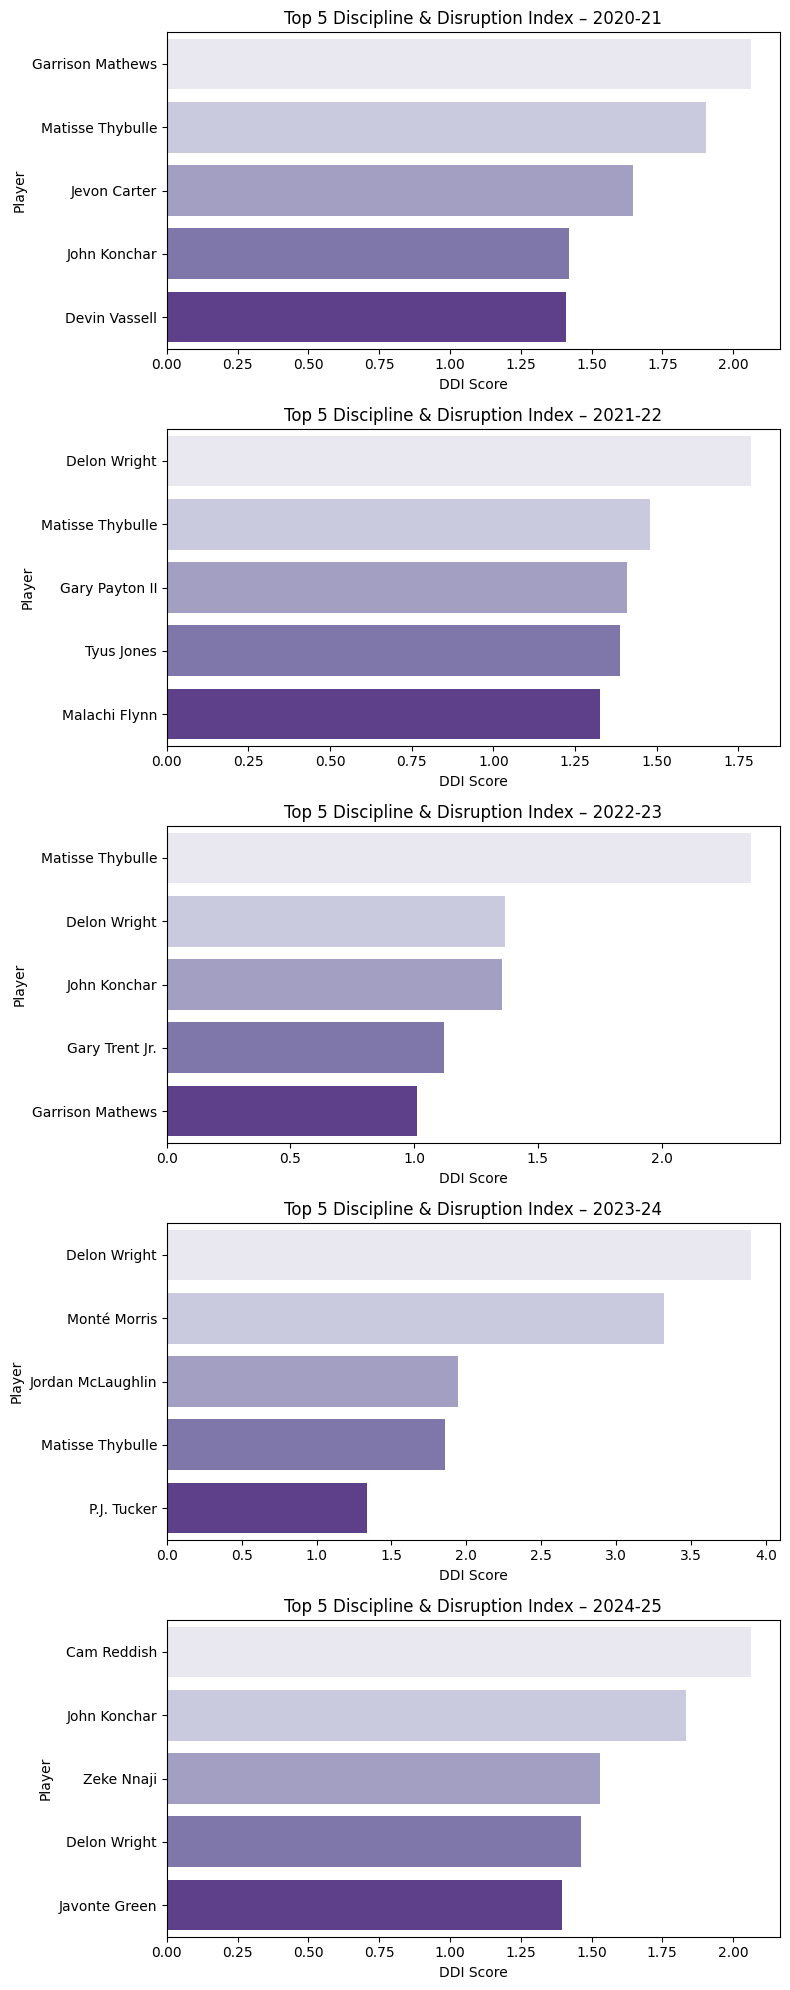

📁 Saved: ddi_leaders_alltime_2020_25.csv


/tmp/ipython-input-3295480521.py:109: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="DDI", y=ddi_alltime.index, data=ddi_alltime, palette="mako")


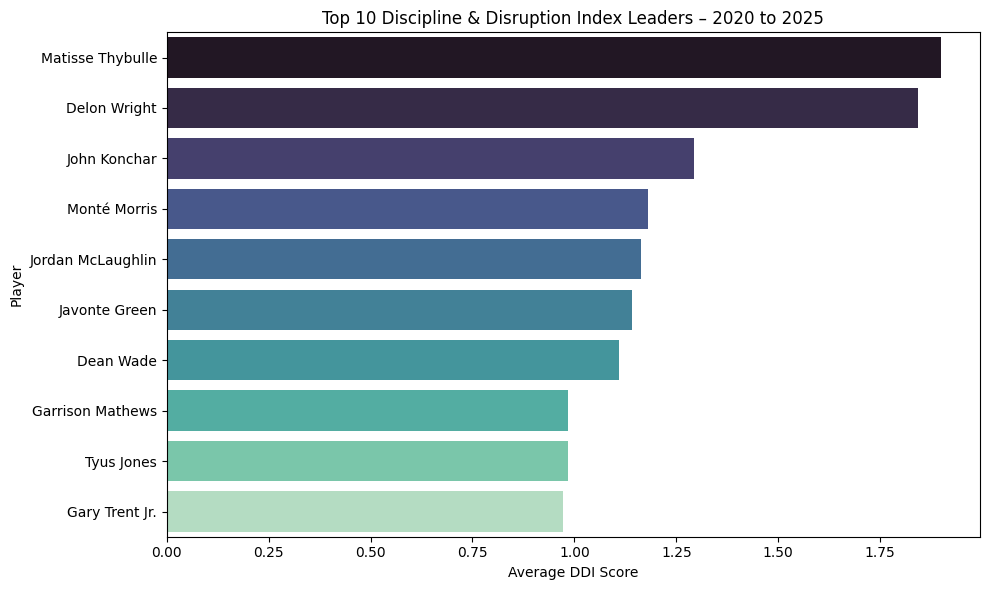

In [20]:
# 📓 Statline: Discipline & Disruption Index (DDI) – 2020 to 2025 (Debug Version)

# 🟦 Step 1: Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

# 🟦 Step 2: Upload your NBA dataset
print("📁 Upload your NBA dataset CSV (2020–2025)")
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# 🟦 Step 3: Load and prepare the dataset
df = pd.read_csv(filename)
df.columns = df.columns.str.strip()

# 🟦 Step 4: Compute per-game and ratio stats
df["MPG"] = df["MIN"] / df["GP"]
df["PF_G"] = df["PF"] / df["GP"]
df["TOV_G"] = df["TOV"] / df["GP"]
df["STL_TOV"] = df["STL"] / (df["TOV"] + 1e-6)

# 🟦 Step 5: Show stat ranges for debugging
print("\n🔍 Stat Ranges Before Filtering:")
print("GP:       ", df["GP"].min(), "-", df["GP"].max())
print("MPG:      ", df["MPG"].min(), "-", df["MPG"].max())
print("STL_TOV:  ", df["STL_TOV"].min(), "-", df["STL_TOV"].max())

# 🟦 Step 6: Filter players with stats from 5 unique seasons
player_season_counts = df.groupby("PLAYER")["Year"].nunique()
eligible_players = player_season_counts[player_season_counts >= 5].index

df = df[df["PLAYER"].isin(eligible_players)].copy()

# Apply gameplay quality filters
df = df[df["TOV"] > 0]  # avoid divide by zero
df["STL_TOV"] = df["STL"] / df["TOV"]
df["MPG"] = df["MIN"] / df["GP"]
df["PF_G"] = df["PF"] / df["GP"]
df["TOV_G"] = df["TOV"] / df["GP"]

# Final filtered dataset
df_filtered = df[
    (df["GP"] >= 20) &         # played enough games in season
    (df["MPG"] >= 10) &        # regular rotation player
    (df["STL_TOV"] >= 0.2)     # some disruption capability
].copy()

print(f"\n✅ Players with data in 5 seasons: {len(eligible_players)}")
print(f"✅ Filtered rows after gameplay filters: {len(df_filtered)}")

# 🟦 Step 7: Compute DDI
df_filtered["DDI"] = (df_filtered["STL_TOV"] * 2) / (df_filtered["TOV_G"] + df_filtered["PF_G"] + 1)

# 🟦 Step 8: Top 5 DDI Players Per Year
if not df_filtered.empty:
    ddi_per_year = df_filtered.groupby("Year", group_keys=False).apply(
        lambda x: x.sort_values(by="DDI", ascending=False).head(5)
    ).reset_index(drop=True)

    ddi_per_year.to_csv("ddi_leaders_per_year_2020_25.csv", index=False)
    print("📁 Saved: ddi_leaders_per_year_2020_25.csv")

    years = sorted(ddi_per_year["Year"].unique())
    fig, axes = plt.subplots(len(years), 1, figsize=(8, len(years) * 4))
    if len(years) == 1:
        axes = [axes]

    for i, year in enumerate(years):
        year_data = ddi_per_year[ddi_per_year["Year"] == year]
        sns.barplot(x="DDI", y="PLAYER", data=year_data, palette="Purples", ax=axes[i])
        axes[i].set_title(f"Top 5 Discipline & Disruption Index – {year}")
        axes[i].set_xlabel("DDI Score")
        axes[i].set_ylabel("Player")

    plt.tight_layout()
    plt.savefig("top5_ddi_per_year_2020_25.jpg", dpi=300)
    plt.show()
else:
    print("⚠️ No players qualified for per-year DDI leaderboard.")

# 🟦 Step 9: All-Time DDI Leaders (Filtered or not)
if not df_filtered.empty:
    ddi_alltime = df_filtered.groupby("PLAYER").agg({
        "GP": "sum",
        "TOV": "sum",
        "PF": "sum",
        "STL_TOV": "mean",
        "DDI": "mean"
    }).sort_values(by="DDI", ascending=False).head(10)
else:
    # fallback if no players passed filter
    print("⚠️ Using fallback: top 10 players by raw DDI from full dataset.")
    df["DDI"] = (df["STL_TOV"] * 2) / (df["TOV"] / df["GP"] + df["PF"] / df["GP"] + 1)
    ddi_alltime = df.groupby("PLAYER").agg({
        "GP": "sum",
        "TOV": "sum",
        "PF": "sum",
        "STL_TOV": "mean",
        "DDI": "mean"
    }).sort_values(by="DDI", ascending=False).head(10)

ddi_alltime.to_csv("ddi_leaders_alltime_2020_25.csv")
print("📁 Saved: ddi_leaders_alltime_2020_25.csv")

# 🟦 Step 10: Visualize All-Time DDI Top 10
plt.figure(figsize=(10,6))
sns.barplot(x="DDI", y=ddi_alltime.index, data=ddi_alltime, palette="mako")
plt.title("Top 10 Discipline & Disruption Index Leaders – 2020 to 2025")
plt.xlabel("Average DDI Score")
plt.ylabel("Player")
plt.tight_layout()
plt.savefig("top10_ddi_alltime_2020_25.jpg", dpi=300)
plt.show()